# Pion Stop Regressor

Train the downstream pion-stop quantile regressor using aligned upstream predictions from group-classifier, group-splitter, endpoint-regressor, and event-splitter outputs.

In [1]:
from pathlib import Path

from pioneerml.common.evaluation.plots.loss import LossCurvesPlot
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import pion_stop_regression_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)

PIPELINE = pion_stop_regression_pipeline
MODEL_SUBDIR = "pion_stop_regression"

Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Build aligned parquet + upstream prediction inputs.
# Expected prediction shard naming: ml_output_XXX_preds.parquet

def _pick_pred(pred_dir: Path, main_path: Path) -> Path | None:
    candidates = [
        pred_dir / f"{main_path.stem}_preds.parquet",
        pred_dir / f"{main_path.stem}_preds_latest.parquet",
    ]
    for c in candidates:
        if c.exists():
            return c
    return None

data_dir = Path(PROJECT_ROOT) / "data"
main_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
main_paths = main_paths[:1]

if not main_paths:
    raise RuntimeError(f"No main parquet files found in {data_dir}")

group_probs_dir = data_dir / "group_classifier"
group_splitter_dir = data_dir / "group_splitter"
endpoint_dir = data_dir / "endpoint_regressor"
event_splitter_dir = data_dir / "event_splitter"

aligned: list[tuple[Path, Path, Path, Path, Path]] = []
for main in main_paths:
    gp = _pick_pred(group_probs_dir, main)
    gs = _pick_pred(group_splitter_dir, main)
    ep = _pick_pred(endpoint_dir, main)
    es = _pick_pred(event_splitter_dir, main)
    if not (gp and gs and ep and es):
        missing = []
        if gp is None:
            missing.append("group_classifier")
        if gs is None:
            missing.append("group_splitter")
        if ep is None:
            missing.append("endpoint_regressor")
        if es is None:
            missing.append("event_splitter")
        raise RuntimeError(f"Missing aligned predictions for {main.name}: {', '.join(missing)}")
    aligned.append((main, gp, gs, ep, es))

parquet_paths = [str(m.resolve()) for (m, _, _, _, _) in aligned]
group_probs_parquet_paths = [str(gp.resolve()) for (_, gp, _, _, _) in aligned]
group_splitter_parquet_paths = [str(gs.resolve()) for (_, _, gs, _, _) in aligned]
endpoint_parquet_paths = [str(ep.resolve()) for (_, _, _, ep, _) in aligned]
event_splitter_parquet_paths = [str(es.resolve()) for (_, _, _, _, es) in aligned]

print(f"Using {len(parquet_paths)} aligned shard(s)")
for p in parquet_paths:
    print(" -", p)


Using 1 aligned shard(s)
 - /workspace/data/ml_output_000.parquet


In [3]:
# Run the pipeline
base_loader_config = {
    "mode": "train",
    "batch_size": 64,
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "use_group_probs": True,
    "use_splitter_probs": True,
    "use_endpoint_preds": True,
    "use_event_splitter_affinity": True,
    "training_relevant_only": True,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

pipeline_config = {
    "loader": {"config_json": {"mode": "train"}},
    "hpo": {
        "enabled": True,
        "n_trials": 4,
        "max_epochs": 10,
        "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/pion_stop_hpo.db",
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 3,
            "min_delta": 0.01,
            "min_delta_mode": "relative",
        },
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train", "sample_fraction": 0.25},
            "val": {"split": "val", "sample_fraction": 0.25},
        },
    },
    "train": {
        "max_epochs": 25,
        "compile": {"enabled": False, "mode": "reduce-overhead"},
        "early_stopping": {
            "enabled": True,
            "monitor": "val_loss",
            "mode": "min",
            "patience": 5,
            "min_delta": 0.005,
            "min_delta_mode": "relative",
        },
        "loader_config": {
            "base": dict(base_loader_config),
            "train": {"split": "train"},
            "val": {"split": "val"},
        },
    },
    "evaluate": {
        "loader_config": {
            "base": dict(base_loader_config),
            "evaluate": {"split": "test"},
        },
    },
    "export": {
        "prefer_cuda": True,
        "export_dir": str(PROJECT_ROOT / "trained_models" / MODEL_SUBDIR),
    },
}

run = PIPELINE.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    group_probs_parquet_paths=group_probs_parquet_paths,
    group_splitter_parquet_paths=group_splitter_parquet_paths,
    endpoint_parquet_paths=endpoint_parquet_paths,
    event_splitter_parquet_paths=event_splitter_parquet_paths,
    pipeline_config=pipeline_config,
)

Initiating a new run for the pipeline: pion_stop_regression_pipeline.
Caching is disabled by default for pion_stop_regression_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step load_pion_stop_dataset has started.
Step load_pion_stop_dataset has finished in 0.148s.
Step tune_pion_stop has started.


[I 2026-02-19 03:48:27,700] Using an existing study with name 'pion_stop_hpo' instead of creating a new one.


[tune_pion_stop] GPU available: True (cuda), used: True
[tune_pion_stop] TPU available: False, using: 0 TPU cores
[tune_pion_stop] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_pion_stop] You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set torch.set_float32_matmul_precision('medium' | 'high') which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[tune_pion_stop] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor   │  3.6 M │ train │     0 │
│ 1 │ loss_fn │ QuantilePinballLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 3.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.6 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 60                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_pion_stop] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_pion_stop] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[tune_pion_stop] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-19 03:48:40,400] Trial 4 finished with value: 1.7872867584228516 and parameters: {'batch_size_exp': 7, 'heads': 6, 'hidden': 300, 'layers': 3, 'dropout': 0.27929283272485284, 'lr': 0.00030052762888245444, 'weight_decay': 6.32405359886332e-05}. Best is trial 0 with value: 1.531536340713501.


[tune_pion_stop] GPU available: True (cuda), used: True
[tune_pion_stop] TPU available: False, using: 0 TPU cores
[tune_pion_stop] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_pion_stop] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor   │  4.3 M │ train │     0 │
│ 1 │ loss_fn │ QuantilePinballLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 76                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_pion_stop] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-19 03:48:51,402] Trial 5 finished with value: 1.5765483379364014 and parameters: {'batch_size_exp': 7, 'heads': 7, 'hidden': 287, 'layers': 4, 'dropout': 0.02966343989695471, 'lr': 0.004030458398207341, 'weight_decay': 2.1820266912242575e-06}. Best is trial 0 with value: 1.531536340713501.


[tune_pion_stop] GPU available: True (cuda), used: True
[tune_pion_stop] TPU available: False, using: 0 TPU cores
[tune_pion_stop] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_pion_stop] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor   │  522 K │ train │     0 │
│ 1 │ loss_fn │ QuantilePinballLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 522 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 522 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 44                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_pion_stop] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-19 03:49:00,211] Trial 6 finished with value: 1.6566849946975708 and parameters: {'batch_size_exp': 7, 'heads': 8, 'hidden': 136, 'layers': 2, 'dropout': 0.15300581753496859, 'lr': 0.0017434490500887842, 'weight_decay': 0.0007862844552513185}. Best is trial 0 with value: 1.531536340713501.


[tune_pion_stop] GPU available: True (cuda), used: True
[tune_pion_stop] TPU available: False, using: 0 TPU cores
[tune_pion_stop] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[tune_pion_stop] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor   │  862 K │ train │     0 │
│ 1 │ loss_fn │ QuantilePinballLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 862 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 862 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 76                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[tune_pion_stop] Trainer.fit stopped: max_epochs=10 reached.


[I 2026-02-19 03:49:11,475] Trial 7 finished with value: 1.6094099283218384 and parameters: {'batch_size_exp': 6, 'heads': 8, 'hidden': 128, 'layers': 4, 'dropout': 0.17135574224845643, 'lr': 0.0006357067249840123, 'weight_decay': 0.0003113519802025324}. Best is trial 0 with value: 1.531536340713501.


Step tune_pion_stop has finished in 43.979s.
Step train_pion_stop has started.
[train_pion_stop] GPU available: True (cuda), used: True
[train_pion_stop] TPU available: False, using: 0 TPU cores
[train_pion_stop] 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
[train_pion_stop] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ PionStopRegressor   │  907 K │ train │     0 │
│ 1 │ loss_fn │ QuantilePinballLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 907 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 907 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 60                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_pion_stop] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_pion_stop] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



[train_pion_stop] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_pion_stop has finished in 46.675s.
Step evaluate_pion_stop has started.
Step evaluate_pion_stop has finished in 0.984s.
Step export_pion_stop has started.
Step export_pion_stop has finished in 0.903s.
Pipeline run has finished in 1m35s.


In [4]:
trained_module = load_step_output(run, "train_pion_stop")
hpo_params = load_step_output(run, "tune_pion_stop")
metrics = load_step_output(run, "evaluate_pion_stop")
export = load_step_output(run, "export_pion_stop")

print("hpo_params:", hpo_params)
if trained_module is not None:
    print("train_epoch_loss_history:", list(trained_module.train_epoch_loss_history))
    print("val_epoch_loss_history:", list(trained_module.val_epoch_loss_history))
    print("train_step_count:", len(trained_module.train_loss_history))
    print("val_step_count:", len(trained_module.val_loss_history))
print("metrics:", metrics)
print("export:", export)

hpo_params: {'lr': 0.0008623494515564066, 'weight_decay': 4.815754900718678e-06, 'batch_size': 64, 'study_name': 'pion_stop_hpo', 'storage': 'sqlite:////workspace/.optuna/pion_stop_hpo.db', 'model': {'in_channels': 4, 'group_prob_dimension': 3, 'splitter_prob_dimension': 3, 'endpoint_pred_dimension': 18, 'event_affinity_dimension': 3, 'pion_stop_pred_dimension': 0, 'hidden': 150, 'heads': 6, 'layers': 3, 'dropout': 0.1422917016971127, 'output_dim': 9}}
train_epoch_loss_history: [1.9345676840424733, 1.2974034199542968, 1.007868486174585, 0.7900162650891099, 0.6890157879667079, 0.6606242102608938, 0.6150244305888877, 0.6000413036921995, 0.5768865358614883, 0.5664416204302674, 0.5630353221916723, 0.5715341491414365, 0.5562529600486037, 0.5517959105500223, 0.5533117639257553, 0.5484042562751645, 0.5544264901874498, 0.5530755214039511, 0.5571519641995235, 0.5462989787618384, 0.5562012991616456, 0.5527885365505656]
val_epoch_loss_history: [2.437040090560913, 1.414792279402415, 1.238060170014

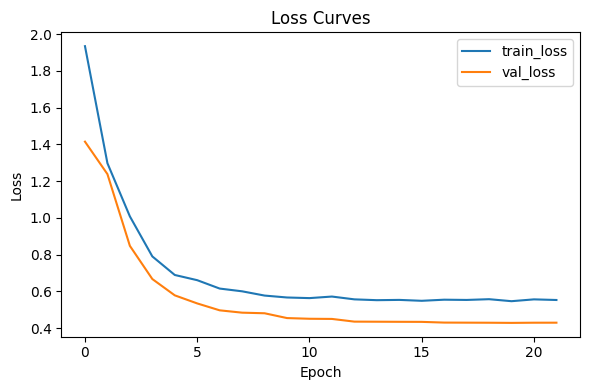

In [5]:
if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")
LossCurvesPlot().render(trained_module, show=True)